In [1]:
# DataCamp Lyric Analysis of Prince Songs tutorial by Debbie Liske in R
# adapted for Python, Thanks Debbie!
# https://www.datacamp.com/community/tutorials/R-nlp-machine-learning
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

In [2]:
prince_orig = pd.read_csv('prince_raw_data.csv',header = 0)
prince_orig.head(6)
#prince.tail(6)

,X,text,artist,song,year,album,Release.Date,US.Pop,US.R.B,CA,UK,IR,NL,DE,AT,FR,JP,AU,NZ,peak
0,49,All 7 and we'll watch them fall\nThey stand in...,prince,7,1992.0,Symbol,17 Nov. 1992,7,61,3,27,-,28,77,-,53,-,25,12,3.0
1,669,"319, 'bout time, come in, ow, 319\nTake off yo...",prince,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78,"Don't worry, I won't hurt you\nI only want you...",prince,1999,1982.0,1999,24 Sep. 1982,12,4,6,25,21,13,86,-,-,-,2,4,2.0
3,475,Prince\nMiscellaneous\n2020\nThe year is 2020 ...,prince,2020,NaN,Other Songs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,811,"One mix, one mix, one mix, one mix\nOne mix, o...",prince,3121,2006.0,3121,21 Mar. 2006,1,1,5,9,23,3,4,15,8,?,18,-,1.0
5,478,"Prince\nMiscellaneous\n777-9311\nBaby, what's ...",prince,7779311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# change the column name 'text' to 'lyric'
prince_orig.rename(columns={'text':'lyric'}, inplace=True)
prince_orig.rename(columns={'US.Pop':'us_pop'}, inplace=True)
prince_orig.rename(columns={'US.R.B':'us_rnb'}, inplace=True)
prince_orig.head(6)

,X,lyric,artist,song,year,album,Release.Date,us_pop,us_rnb,CA,UK,IR,NL,DE,AT,FR,JP,AU,NZ,peak
0,49,All 7 and we'll watch them fall\nThey stand in...,prince,7,1992.0,Symbol,17 Nov. 1992,7,61,3,27,-,28,77,-,53,-,25,12,3.0
1,669,"319, 'bout time, come in, ow, 319\nTake off yo...",prince,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78,"Don't worry, I won't hurt you\nI only want you...",prince,1999,1982.0,1999,24 Sep. 1982,12,4,6,25,21,13,86,-,-,-,2,4,2.0
3,475,Prince\nMiscellaneous\n2020\nThe year is 2020 ...,prince,2020,NaN,Other Songs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,811,"One mix, one mix, one mix, one mix\nOne mix, o...",prince,3121,2006.0,3121,21 Mar. 2006,1,1,5,9,23,3,4,15,8,?,18,-,1.0
5,478,"Prince\nMiscellaneous\n777-9311\nBaby, what's ...",prince,7779311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# create a smaller dataframe using loc function to select 'lyric','song','year','album','peak','us_pop','us_rnb'
prince = prince_orig.loc[:,['lyric','song','year','album','peak','us_pop','us_rnb',]]
prince.head(6)

,lyric,song,year,album,peak,us_pop,us_rnb
0,All 7 and we'll watch them fall\nThey stand in...,7,1992.0,Symbol,3.0,7,61
1,"319, 'bout time, come in, ow, 319\nTake off yo...",319,NaN,NaN,NaN,NaN,NaN
2,"Don't worry, I won't hurt you\nI only want you...",1999,1982.0,1999,2.0,12,4
3,Prince\nMiscellaneous\n2020\nThe year is 2020 ...,2020,NaN,Other Songs,NaN,NaN,NaN
4,"One mix, one mix, one mix, one mix\nOne mix, o...",3121,2006.0,3121,1.0,1,1
5,"Prince\nMiscellaneous\n777-9311\nBaby, what's ...",7779311,NaN,NaN,NaN,NaN,NaN


In [5]:
prince.dtypes

lyric      object
song       object
year      float64
album      object
peak      float64
us_pop     object
us_rnb     object
dtype: object

In [6]:
# replace Nan's in 'year' column with a 0
prince['year'] = prince['year'].fillna(0)

In [7]:
def decades(year):
    decade = '1970s'
    if year == 0:
        decade = 'unknown'
    elif (1969 <year < 1980):
        pass
    elif (1979 <year < 1990):
        decade  ='1980s'
    elif(1989 <year < 2000):
        decade = '1990s'
    elif(2000 <=year < 2010):
        decade = '2000s'
    else:
        decade = '2010s'
    return decade
    

In [8]:
#prince['decades'] =  prince.apply(decades, prince['year'])
prince['decades'] = prince['year'].apply(decades)

In [9]:
def chart_level(peak):
    level = 'Uncharted'
    if (0 <peak < 11):
        level = 'Top 10'
    elif(10 < peak < 101):
        level = 'Top 100'
    return level

def charted(peak):
    status = 'Uncharted'
    if (0 <peak < 101):
        status = 'Charted'
    return status


In [10]:
prince['chart_level'] = prince['peak'].apply(chart_level)
prince['charted'] = prince['peak'].apply(charted)

In [11]:
#prince.tail(16)
prince.head(10)

,lyric,song,year,album,peak,us_pop,us_rnb,decades,chart_level,charted
0,All 7 and we'll watch them fall\nThey stand in...,7,1992.0,Symbol,3.0,7,61,1990s,Top 10,Charted
1,"319, 'bout time, come in, ow, 319\nTake off yo...",319,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted
2,"Don't worry, I won't hurt you\nI only want you...",1999,1982.0,1999,2.0,12,4,1980s,Top 10,Charted
3,Prince\nMiscellaneous\n2020\nThe year is 2020 ...,2020,0.0,Other Songs,NaN,NaN,NaN,unknown,Uncharted,Uncharted
4,"One mix, one mix, one mix, one mix\nOne mix, o...",3121,2006.0,3121,1.0,1,1,2000s,Top 10,Charted
5,"Prince\nMiscellaneous\n777-9311\nBaby, what's ...",7779311,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted
6,"u, you're so fine\nSeems to happen to me eac...",u,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted
7,ed if I do\nTell me what's up with the teenag...,ed if i do,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted
8,Nuestra presentacion especial comenzara en bre...,control,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted
9,"Ohh, ah, yeah\nU work so hard, U really do\nI ...",1000 xs os,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted


In [12]:
def lower_case(phrase):
    return phrase.lower()

prince['lyric'] = prince['lyric'].apply(lower_case)

In [13]:
# Borrowed this function from Yann Dubois on stackoverflow 

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\n", " ", phrase)
    return phrase


my_str = "I can't do that! In fact, I won't do that! Just won't do it!"
#print(my_str)
str2 = decontracted(my_str)
#print
print(str2)

I can not do that! In fact, I will not do that! Just will not do it!


In [14]:
# clean up lyrics by removing contractions
prince['lyric'] = prince['lyric'].apply(decontracted)
#prince['lyric'] = prince['lyric'].apply(replace('\n',''))
prince.head(36)

,lyric,song,year,album,peak,us_pop,us_rnb,decades,chart_level,charted
0,all 7 and we will watch them fall they stand i...,7,1992.0,Symbol,3.0,7,61,1990s,Top 10,Charted
1,"319, 'bout time, come in, ow, 319 take off you...",319,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted
2,"do not worry, i will not hurt you i only want ...",1999,1982.0,1999,2.0,12,4,1980s,Top 10,Charted
3,prince miscellaneous 2020 the year is 2020 an...,2020,0.0,Other Songs,NaN,NaN,NaN,unknown,Uncharted,Uncharted
4,"one mix, one mix, one mix, one mix one mix, on...",3121,2006.0,3121,1.0,1,1,2000s,Top 10,Charted
5,"prince miscellaneous 777-9311 baby, what is yo...",7779311,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted
6,"u, you are so fine seems to happen to me eac...",u,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted
7,ed if i do tell me what is up with the teenag...,ed if i do,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted
8,nuestra presentacion especial comenzara en bre...,control,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted
9,"ohh, ah, yeah u work so hard, u really do i do...",1000 xs os,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted


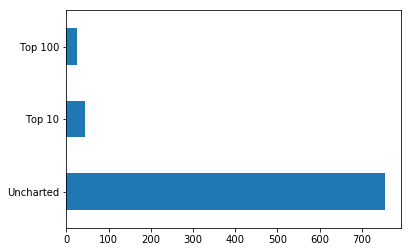

In [15]:
%matplotlib inline
prince['chart_level'].value_counts()[:20].plot(kind='barh')

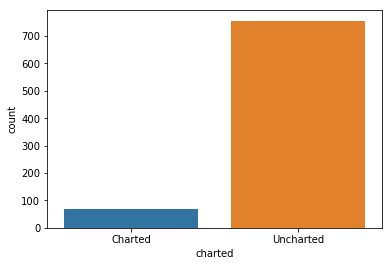

In [16]:
ax = sns.countplot(x="charted", data=prince)

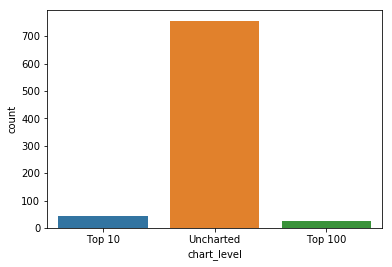

In [17]:
ax = sns.countplot(x="chart_level", data=prince)

In [18]:
#filter out uncharted data and plot value count for Top 10 & Top 100 Prince songs
songs = prince['chart_level']
chart_data = prince.loc[prince['chart_level'].isin(['Top 10', 'Top 100'])] 
#top_songs = chart_data['chart_level']
#print(chart_data)
top_10 = [x for x in songs if x == 'Top 10']
top_100 = [x for x in songs if x == 'Top 100']
print
print(top_10)
print(len(top_10))
print
print(top_100)
print(len(top_100))
print


['Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10', 'Top 10']
43
['Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100', 'Top 100']
25


<function print>

In [19]:
chart_data.head(10)

,lyric,song,year,album,peak,us_pop,us_rnb,decades,chart_level,charted
0,all 7 and we will watch them fall they stand i...,7,1992.0,Symbol,3.0,7,61,1990s,Top 10,Charted
2,"do not worry, i will not hurt you i only want ...",1999,1982.0,1999,2.0,12,4,1980s,Top 10,Charted
4,"one mix, one mix, one mix, one mix one mix, on...",3121,2006.0,3121,1.0,1,1,2000s,Top 10,Charted
25,if i never get to hold your hand if i never ge...,4ever,2009.0,LotusFlow3r,4.0,35,4,2000s,Top 10,Charted
62,"yeah (shotgun) peace eh, yeah, eh, eh, yeah, e...",america,1985.0,Around the World in a Day,35.0,47,35,1980s,Top 100,Charted
71,"i gave my love, i gave my life i gave my body ...",anotherloverholenyohead,1986.0,Parade,15.0,63,18,1980s,Top 100,Charted
72,prince around the world in a day around the wo...,around the world in a day,1985.0,Around the World in a Day,1.0,1,4,1980s,Top 10,Charted
86,"prince batman batdance oh, i got a live one he...",batdance,1989.0,Batman,1.0,1,1,1980s,Top 10,Charted
93,this might seem strange since so much time has...,better with time,2009.0,MPLSoUND,78.0,-,78,2000s,Top 100,Charted
100,i do not want to take my clothes off but i do ...,black sweat,2006.0,3121,43.0,60,82,2000s,Top 100,Charted


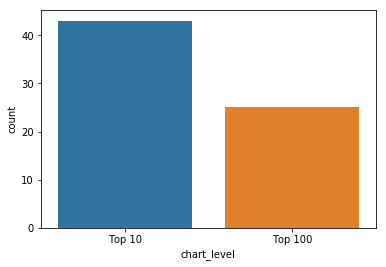

In [20]:
ax = sns.countplot(x="chart_level", data=chart_data)

In [21]:
#Group By decades
#groupbydecades = prince.groupby(['decades']).size()
groupbydecades = chart_data.groupby(['decades', 'chart_level']).size()
#prince.groupby([‘decades’])
print(groupbydecades)

decades  chart_level
1970s    Top 10          1
         Top 100         3
1980s    Top 10         24
         Top 100         7
1990s    Top 10         14
         Top 100         9
2000s    Top 10          4
         Top 100         6
dtype: int64


In [22]:
# Finally figured out how to create stacked barplot with pandas after many hours
# pd.crosstab is the key 
# compare with above graph with unstacked bars
decade_chart = pd.crosstab(index=prince["decades"], 
                           columns=prince["chart_level"])
#decade_chart = pd.crosstab(index=chart_data["decades"], 
                           #columns=chart_data["chart_level"])
decade_chart.index= ["1970s","1980s","1990s","2000s","2010s","unknown"]

decade_chart


chart_level,Top 10,Top 100,Uncharted
1970s,1,3,10
1980s,24,7,46
1990s,14,9,137
2000s,4,6,48
2010s,0,0,20
unknown,0,0,495


In [23]:
# Drop Uncharted column from decade_chart dataframe
# Drop the unknown row from decade_chart dataframe
decade_chart = decade_chart.drop(['Uncharted'], axis=1)
decade_chart = decade_chart.drop(['unknown'], axis=0)
decade_chart

chart_level,Top 10,Top 100
1970s,1,3
1980s,24,7
1990s,14,9
2000s,4,6
2010s,0,0


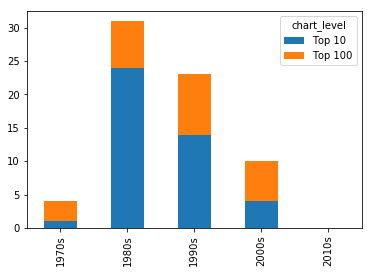

In [24]:
decade_chart.plot(kind='bar',stacked=True)

In [25]:
lyric1 = prince['lyric'][0]
#print(lyric1)
words1 = lyric1.split(" ")
#print(words)

In [26]:
# Use the nltk(Natural Langauge Tool Kit) module for counting frequency of words in lyrics
fdist = nltk.FreqDist(words1)


In [27]:
for word, frequency in fdist.most_common(10):
    print(u'{}:{}'.format(word, frequency))

and:35
will:30
we:18
all:16
the:16
in:13
of:12
them:11
7:9
love:9


In [28]:
undesirable_words = ["prince","chorus","repeat","lyrics","themes","bridge","fe0f","yeah","baby",\
                    "alright","wanna","gonna","chorus","verse",\
                    "whoa","gotta","make", "miscellaneous", "2"\
                    "4","ooh", "uurh", "pheromone", "poompoom", "3121",\
                    "matic", " ai ", " ca ", " la ", "hey", " na ",\
                    " da ", " uh ", " tin ", "  ll", "transcription",\
                    "repeats","the",","]



In [29]:
def filtered(wrds):
    #This function returns a filtered list
    # by removing stopwords and other undesirable words
    undesirable_words = ["prince","chorus","repeat","lyrics","themes","bridge","fe0f","yeah","baby",\
                    "alright","wanna","gonna","chorus","verse",\
                    "whoa","gotta","make", "miscellaneous", "2"\
                    "4","ooh", "uurh", "you","yes","yet","pheromone", "poompoom", "3121",\
                    "matic", " ai ", " ca ","know","ai","la ","like", "hey", " na ",\
                    " da ", "their","one","got"," uh ","u"," tin ", "  ll", "transcription",\
                    "repeats","ever","every","everybody","get","come","the","them",",",")","(",".","-"]
    
    stopWords = set(stopwords.words('english'))
    wordsFiltered = []
    for w in wrds:
        if (w not in stopWords) and (w not in undesirable_words):
            if len(w) > 0:
                wordsFiltered.append(w)
            
    return wordsFiltered

In [30]:
def top_words(wrds,top_num = 10):
    #This function returns the words that appeared most often using NLTK.freqdist
    # by removing stopwords and other undesirable words
    fdist = nltk.FreqDist(wrds)
    
    the_top = fdist.most_common(top_num)
    #print(the_top)
    top_words = []
    for item in the_top:
        top_words.append(item[:][0])
            
    return top_words

In [31]:
decades = prince['lyric'].groupby(prince['decades'])

In [32]:
prince['lyric_length'] = prince.lyric.apply(len)

In [33]:

prince['lyric_words'] = prince['lyric'].str.split(" ")

In [34]:
word_list_70s = []
for item in (prince[prince.decades=='1970s'].lyric_words):
    word_list_70s.extend(item)

filter_70s = filtered(word_list_70s)

In [35]:
fdist_70s = nltk.FreqDist(filter_70s)
fdist_70s.most_common(10)
top_ten_70s = fdist_70s.most_common(10)
print(top_ten_70s)

[('love', 56), ('baby,', 35), ('you,', 26), ('sexy', 25), ("waitin'", 20), ('dancer,', 18), ('still', 17), ('feel', 16), ('want', 15), ('oh', 13)]


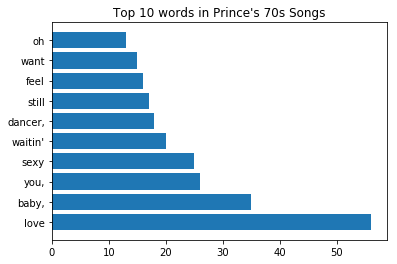

In [36]:
names = []
values = []
for item in top_ten_70s:
    names.append(item[0])
    values.append(item[1])
print()
#print(names)
#print()
#print(values)
print()
#plt.bar(range(len(names)),values,tick_label=names)
plt.barh(range(len(names)),values,tick_label=names)
#plt.barh(range(values,len(names)),tick_label=names)
plt.title("Top 10 words in Prince's 70s Songs")
#plt.savefig('bar.png')
plt.show()

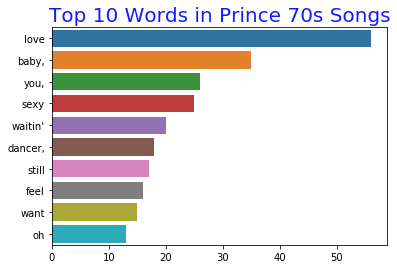

In [37]:
g = sns.barplot(x =values, y = names )
g.axes.set_title('Top 10 Words in Prince 70s Songs', fontsize=20,color="b",alpha=0.9)

In [38]:
word_list_80s = []
for item in (prince[prince.decades=='1980s'].lyric_words):
    word_list_80s.extend(item)
#print(type(word_list_80s))
#print(len(word_list_80s))

In [39]:
filter_80s = filtered(word_list_80s)
print()
print(len(word_list_80s))
print()
print(len(filter_80s))


23917

10646


[('love', 206), ('want', 103), ('yeah,', 95), ('time', 89), ('say', 82), ('let', 78), ('baby,', 77), ('2', 71), ('party', 68), ('would', 65)]



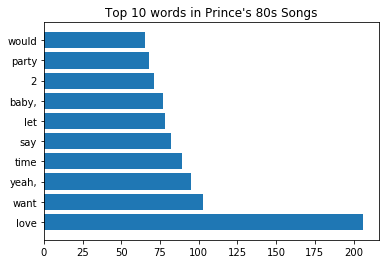

In [40]:
fdist_80s = nltk.FreqDist(filter_80s)
fdist_80s.most_common(10)
top_ten_80s = fdist_80s.most_common(10)
print(top_ten_80s)
#top_ten_80s.plot(30,cumulative=False)
names = []
values = []
for item in top_ten_80s:
    names.append(item[0])
    values.append(item[1])
#print()
#print(names)
#print()
#print(values)
print()
#plt.bar(range(len(names)),values,tick_label=names)
plt.barh(range(len(names)),values,tick_label=names)
plt.title("Top 10 words in Prince's 80s Songs")
#plt.savefig('bar.png')
plt.show()

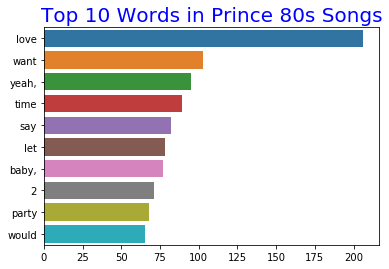

In [41]:
g = sns.barplot(x =values, y = names )
g.axes.set_title('Top 10 Words in Prince 80s Songs', fontsize=20,color="b",alpha= 1.0)

In [42]:
word_list_90s = []
for item in (prince[prince.decades=='1990s'].lyric_words):
    word_list_90s.extend(item)
    
filter_90s = filtered(word_list_90s)

fdist_90s = nltk.FreqDist(filter_90s)
fdist_90s.most_common(10)
top_ten_90s = fdist_90s.most_common(10)
print(top_ten_90s)

[('love', 277), ('2', 252), ('yeah,', 226), ('baby,', 224), ('would', 217), ('let', 201), ('oh', 175), ('see', 166), ('go', 156), ('want', 155)]



['love', '2', 'yeah,', 'baby,', 'would', 'let', 'oh', 'see', 'go', 'want']

[277, 252, 226, 224, 217, 201, 175, 166, 156, 155]



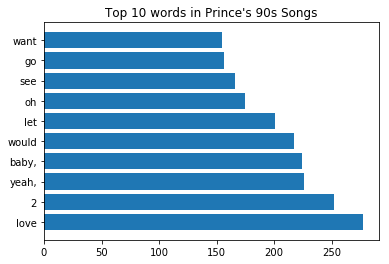

In [43]:
names = []
values = []
for item in top_ten_90s:
    names.append(item[0])
    values.append(item[1])
print()
print(names)
print()
print(values)
print()
#plt.bar(range(len(names)),values,tick_label=names)
plt.barh(range(len(names)),values,tick_label=names)
#plt.savefig('bar.png')
plt.title("Top 10 words in Prince's 90s Songs")
plt.show()

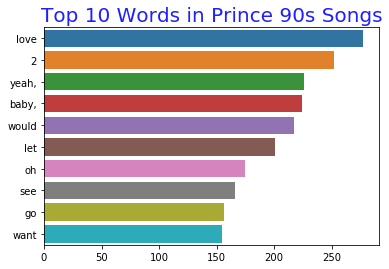

In [44]:
g = sns.barplot(x =values, y = names )
# Set the Title of the graph from here
g.axes.set_title('Top 10 Words in Prince 90s Songs', fontsize=20,color="b",alpha=0.88)

In [45]:
word_list_2000s = []
for item in (prince[prince.decades=='2000s'].lyric_words):
    word_list_2000s.extend(item)
    
filter_2000s = filtered(word_list_2000s)

fdist_2000s = nltk.FreqDist(filter_2000s)
fdist_2000s.most_common(10)
top_ten_2000s = fdist_2000s.most_common(10)
print(top_ten_2000s)

[('eye', 103), ('love', 76), ('want', 59), ('let', 58), ('would', 57), ('never', 56), ('see', 48), ('tell', 37), ('go', 34), ('time', 34)]



['eye', 'love', 'want', 'let', 'would', 'never', 'see', 'tell', 'go', 'time']

[103, 76, 59, 58, 57, 56, 48, 37, 34, 34]



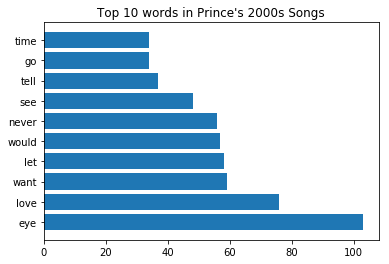

In [46]:
names = []
values = []
for item in top_ten_2000s:
    names.append(item[0])
    values.append(item[1])
print()
print(names)
print()
print(values)
print()
#plt.bar(range(len(names)),values,tick_label=names)
plt.barh(range(len(names)),values,tick_label=names)
plt.title("Top 10 words in Prince's 2000s Songs")
#plt.savefig('bar.png')
plt.show()

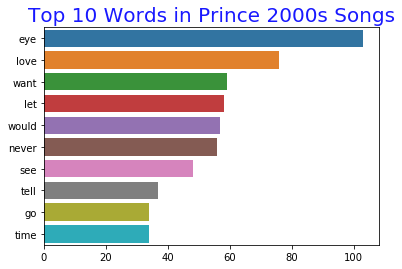

In [47]:
g = sns.barplot(y = names, x =values )
g.axes.set_title('Top 10 Words in Prince 2000s Songs', fontsize=20,color="b",alpha=0.9)

In [48]:
word_list_2010s = []
for item in (prince[prince.decades=='2010s'].lyric_words):
    word_list_2010s.extend(item)
    
filter_2010s = filtered(word_list_2010s)

fdist_2010s = nltk.FreqDist(filter_2010s)
fdist_2010s.most_common(10)
top_ten_2010s = fdist_2010s.most_common(10)
#print(top_ten_2010s)


['could', 'need', 'la', 'us', 'let', 'better', 'nothing', 'hand', 'big', 'love']

[35, 33, 32, 30, 30, 25, 24, 24, 23, 21]



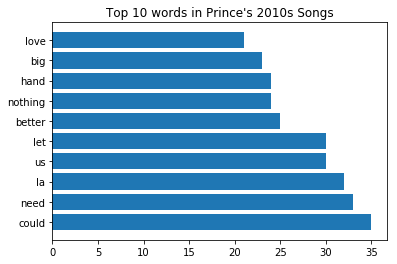

In [49]:
names = []
values = []
for item in top_ten_2010s:
    names.append(item[0])
    values.append(item[1])
print()
print(names)
print()
print(values)
print()
#plt.bar(range(len(names)),values,tick_label=names)
plt.barh(range(len(names)),values,tick_label=names)
plt.title("Top 10 words in Prince's 2010s Songs")
#plt.savefig('bar.png')
plt.show()

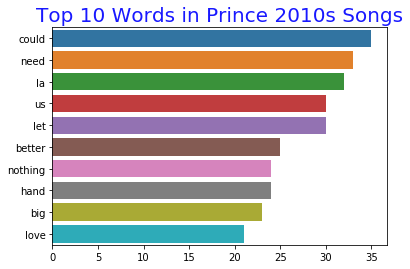

In [50]:
#g = sns.barplot(x = names, y =values )
g = sns.barplot( x =values ,y = names)
g.axes.set_title('Top 10 Words in Prince 2010s Songs', fontsize=20,color="b",alpha=0.9)

In [51]:
print()
print(top_ten_70s)
print()
print(top_ten_80s)
print()
print(top_ten_90s)
print()
print(top_ten_2000s)
print()
print(top_ten_2010s)
print()


[('love', 56), ('baby,', 35), ('you,', 26), ('sexy', 25), ("waitin'", 20), ('dancer,', 18), ('still', 17), ('feel', 16), ('want', 15), ('oh', 13)]

[('love', 206), ('want', 103), ('yeah,', 95), ('time', 89), ('say', 82), ('let', 78), ('baby,', 77), ('2', 71), ('party', 68), ('would', 65)]

[('love', 277), ('2', 252), ('yeah,', 226), ('baby,', 224), ('would', 217), ('let', 201), ('oh', 175), ('see', 166), ('go', 156), ('want', 155)]

[('eye', 103), ('love', 76), ('want', 59), ('let', 58), ('would', 57), ('never', 56), ('see', 48), ('tell', 37), ('go', 34), ('time', 34)]

[('could', 35), ('need', 33), ('la', 32), ('us', 30), ('let', 30), ('better', 25), ('nothing', 24), ('hand', 24), ('big', 23), ('love', 21)]



In [52]:
prince.columns

Index(['lyric', 'song', 'year', 'album', 'peak', 'us_pop', 'us_rnb', 'decades',
       'chart_level', 'charted', 'lyric_length', 'lyric_words'],
      dtype='object')

In [53]:
#prince.index

In [54]:
def top_lyric_words(lyric_wrds):
    word_list = []
    for item in (lyric_wrds):
        word_list.extend(item)
        #word_list.append(item)
    
    filter_list = filtered(word_list)
    fdist_new = nltk.FreqDist(filter_list)
    fdist_new.most_common(10)
    top_ten = fdist_new.most_common(10)
    return top_ten

In [55]:
def top_guns(lyric_wrds):
    
    filter_list = filtered(lyric_wrds)
    fdist_new = nltk.FreqDist(filter_list)
    fdist_new.most_common(10)
    top_ten = fdist_new.most_common(10)
    return top_ten

In [56]:
#prince['most_common_words'] = prince.lyric_words.apply(top_lyric_words)

In [57]:
#prince.head(200)

In [58]:
prince.groupby('decades').lyric_words.agg(top_lyric_words)

decades
1970s      [(love, 56), (baby,, 35), (you,, 26), (sexy, 2...
1980s      [(love, 206), (want, 103), (yeah,, 95), (time,...
1990s      [(love, 277), (2, 252), (yeah,, 226), (baby,, ...
2000s      [(eye, 103), (love, 76), (want, 59), (let, 58)...
2010s      [(could, 35), (need, 33), (la, 32), (us, 30), ...
unknown    [(2, 2122), (love, 1009), (baby,, 639), (let, ...
Name: lyric_words, dtype: object

In [59]:
# Determine the 10 most common words found in all of Prince's songs/lyrics
all_lyric_wrds = []
for item in (prince.lyric_words):
    all_lyric_wrds.extend(item)
    
all_wrds = []
for item in all_lyric_wrds:
    #print(len(item))
    if len(item)> 2:
        all_wrds.append(item)
catbert = [wrd for wrd in all_lyric_wrds if len(wrd) > 3]        
print()        
print(len(all_lyric_wrds))
print()
print(len(catbert))
print()
top_guns(catbert)




292687

140390



[('love', 1645),
 ('baby,', 995),
 ('want', 810),
 ('would', 801),
 ('time', 735),
 ('yeah,', 679),
 ('could', 579),
 ('tell', 577),
 ('never', 563),
 ('take', 484)]

In [60]:

prince.loc[prince['chart_level']== 'Top 10',['lyric_length']].mean()

lyric_length    1557.046512
dtype: float64

In [61]:
prince.loc[prince['chart_level']== 'Top 100',['lyric_length']].mean()

lyric_length    1393.64
dtype: float64

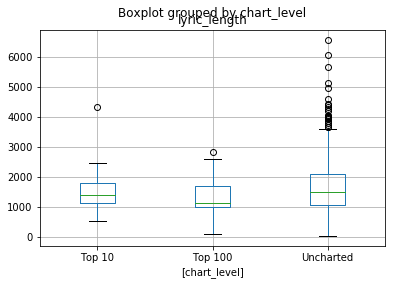

In [62]:
prince.boxplot(column='lyric_length', by=['chart_level'])

In [63]:
#prince['lyric_words_num'] = len(prince['lyric_words'])
prince['lyric_words_num'] = prince['lyric_words'].apply(len)

In [64]:
prince.head()

,lyric,song,year,album,peak,us_pop,us_rnb,decades,chart_level,charted,lyric_length,lyric_words,lyric_words_num
0,all 7 and we will watch them fall they stand i...,7,1992.0,Symbol,3.0,7,61,1990s,Top 10,Charted,2146,"[all, 7, and, we, will, watch, them, fall, the...",469
1,"319, 'bout time, come in, ow, 319 take off you...",319,0.0,NaN,NaN,NaN,NaN,unknown,Uncharted,Uncharted,1075,"[319,, 'bout, time,, come, in,, ow,, 319, take...",233
2,"do not worry, i will not hurt you i only want ...",1999,1982.0,1999,2.0,12,4,1980s,Top 10,Charted,2380,"[do, not, worry,, i, will, not, hurt, you, i, ...",488
3,prince miscellaneous 2020 the year is 2020 an...,2020,0.0,Other Songs,NaN,NaN,NaN,unknown,Uncharted,Uncharted,410,"[prince, miscellaneous, 2020, the, year, is, 2...",88
4,"one mix, one mix, one mix, one mix one mix, on...",3121,2006.0,3121,1.0,1,1,2000s,Top 10,Charted,1408,"[one, mix,, one, mix,, one, mix,, one, mix, on...",286


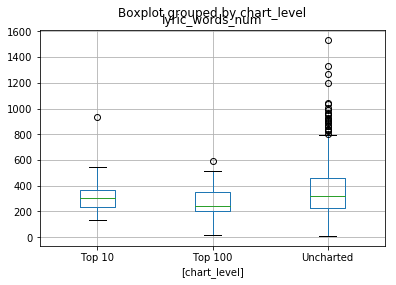

In [65]:
prince.boxplot(column='lyric_words_num', by=['chart_level'])

In [66]:
df_3 = prince[['chart_level','lyric_words_num']]

In [67]:
#df_3
df_3['lyric_words_num'].groupby(prince['chart_level']).mean()

chart_level
Top 10       333.302326
Top 100      290.760000
Uncharted    358.579365
Name: lyric_words_num, dtype: float64

In [68]:
df_3.head(20)

,chart_level,lyric_words_num
0,Top 10,469
1,Uncharted,233
2,Top 10,488
3,Uncharted,88
4,Top 10,286
5,Uncharted,324
6,Uncharted,246
7,Uncharted,257
8,Uncharted,685
9,Uncharted,379
